In [1]:
import numpy as np
from matplotlib import pyplot as plt

#from astroML.density_estimation import XDGMM
#from sklearn.mixture import GaussianMixture
import fitsio as fio
import glob
import os
import math
import matplotlib.colors as clr
from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize
from tqdm import tqdm
from numpy.linalg import inv,det
from scipy.interpolate import interp1d
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
Roman_truth_file = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_truth_gal_icrs.fits'
aa = fio.FITS(Roman_truth_file)[-1]
Roman_z = aa.read_column('z')

Roman_output_dir = '/global/cscratch1/sd/zg64/Rubin-Roman-Redmagic/dc2_sim_output/'
Roman_match_files = np.sort(glob.glob(os.path.join(Roman_output_dir,'*.fits')))
roman_truth = fio.FITS(Roman_match_files[1])[-1].read()
roman_detection = fio.FITS(Roman_match_files[0])[-1].read()

In [6]:
measure_qts_truth = roman_truth[Red_gal_ind]

In [4]:
# Load Seed LRGs
Red_gal_ind = np.load('data/roman_seed_lrg.npy')
roman_ind = roman_truth['ind']
matched_inds_in_truth = roman_ind[Red_gal_ind]

zs = Roman_z[matched_inds_in_truth]
measured_qts = roman_detection[Red_gal_ind]

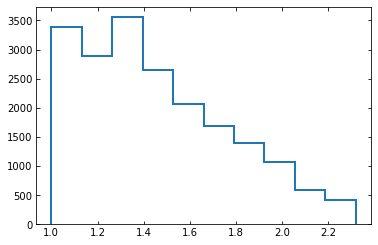

In [5]:
plt.hist(zs,histtype='step',linewidth = 2);

In [7]:
def get_vals (c1,c2,ref_m,z_mask):
    fz = 20
    mag_c1 = measured_qts['mag_auto_%s'%c1][z_mask]
    mag_c2 = measured_qts['mag_auto_%s'%c2][z_mask]
    mag_ref = measured_qts['mag_auto_%s'%ref_m][z_mask]
    
    color = mag_c1-mag_c2
    
    mag_c1_err = measured_qts['magerr_auto_%s'%c1][z_mask]
    mag_c2_err = measured_qts['magerr_auto_%s'%c2][z_mask]
    

    color_err = (mag_c1_err**2 + mag_c2_err**2)
    return(np.mean(mag_ref),mag_ref,color,color_err)

In [8]:
def func (x,mag_ref,m_ref_mean,color,color_err):
    a,b,sigma_int = x
    #a,b = x
    vals = np.zeros(shape = mag_ref.shape)
    for i,m_f in enumerate(mag_ref):
        
        c_model = a + b * (m_f - m_ref_mean)
        
        sigma_photo = color_err[i]
        
        c_gal = color[i]
        
        sigma_tot =sigma_photo + sigma_int
        
        single_gal = (c_gal - c_model)**2*(1/sigma_tot) + math.log((2*np.pi)*sigma_tot)
        
        vals[i] = single_gal
        
    return(np.sum(vals))

In [9]:
def func_tot (x,color1,color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2):
    
    a1,a2,b1,b2,sigma_int1,sigma_int2,r = x
    
   
    #a,b = x
    vals = np.zeros(shape = mag_ref.shape)
    for i,m_f in enumerate(mag_ref):
        
        c1_model = a1 + b1 * (m_f - m_ref_mean)
        c2_model = a2 + b2 * (m_f - m_ref_mean)
        
        color_vec_model = np.array([[c1_model],[c2_model]])
        color_data = np.array([[color1[i]],[color2[i]]])
        
        # difference between model and data 
        vector = color_data - color_vec_model
        
        # Photometric covariance
        C_pho = np.empty((2,2))
        C_pho[0][0] = sigma_c0[i]+sigma_c1[i]    #color_err1[i]
        C_pho[1][1] = sigma_c1[i] + sigma_c2[i]
        C_pho[1][0] = -sigma_c1[i]
        C_pho[0][1] = -sigma_c1[i]
        
        # Red sequence intrinsic scatter covariance
        C_int = np.empty((2,2))
        C_int[0][0] = sigma_int1**2
        C_int[1][1] = sigma_int2**2
        C_int[0][1] = sigma_int1*sigma_int2*0
        C_int[1][0] = sigma_int1*sigma_int2*0
        
        C_tot = C_pho + C_int
        C_inv = inv(C_tot)
        vals[i] = np.linalg.multi_dot([vector.T,C_inv,vector]) + np.log((2*np.pi)*det(C_tot)) + (r/0.45)**2/2.
    return(np.sum(vals))

## Fitting all simultaneously

In [29]:
fr = ['Y106','J129','H158','F184']
z_low = 1.2
z_high = z_low + 0.02
z_mask = (zs > z_low) & (zs < z_high)
m_ref_mean,mag_ref,color1,color2,sigma_c0,sigma_c1,sigma_c2 = get_vals2(c1 = fr[0],c2 = fr[1],c3 = fr[2],ref_m=fr[-1],z_mask=z_mask)
x0 = (1,1,0.5,0.5,0.002,0.002,0)
res = minimize(func_tot,x0,bounds=((None,None),(None,None),(None,None),(None,None),(0,None),(0,None),(None,None)),
              args=(color1, color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2))

In [22]:
res

      fun: -697.7403137271899
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00300133,  0.00022737, -0.16611921])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 208
      nit: 26
     njev: 52
   status: 0
  success: True
        x: array([-0.08122554, -0.00566229,  0.00260707])

## Fitting just the off-diagonal elements

In [31]:
fr = ['Y106','J129','H158','F184']
z_low = 1.2
z_high = z_low + 0.02
z_mask = (zs > z_low) & (zs < z_high)
m_ref_mean,mag_ref,color1,color2,sigma_c0,sigma_c1,sigma_c2 = get_vals2(c1 = fr[0],c2 = fr[1],c3 = fr[2],ref_m=fr[-1],z_mask=z_mask)
x0 = (1)
res = minimize(func_off_diag_only,x0,
              args=(color1, color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2,
                   res_1.x[0],res_1.x[1],res_1.x[2],res_2.x[0],res_2.x[1],res_2.x[2]))

In [32]:
res

      fun: 53245.13130407431
 hess_inv: array([[1.08234338e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.04621063])

## Start with fitting red-sequence template for single color

In [12]:
def plot_model(ax,mag_ref,m_ref_mean,res,c1,c2):
    ax.plot(mag_ref-m_ref_mean,color,'.',label = 'Seed LRGs')
    xx = mag_ref-m_ref_mean
    xx.sort()
    yy = res[0] + res[1]*(xx)
    ax.plot(xx,yy,color = 'red',label = 'Model');
    sigma = np.sqrt(res[2])
    ax.fill_between(xx,(yy-sigma),(yy+sigma),color = 'red',alpha = 0.25,label = r'$1\sigma$')
    ax.fill_between(xx,(yy-sigma*2),(yy+sigma*2),alpha = 0.15,label = r'$2\sigma$')
    ax.set_ylim(yy.mean()-0.5,yy.mean()+0.5)
    ax.set_ylabel('%s - %s'%(c1,c2),fontsize = 15)
    ax.legend(loc = 'best',fontsize = 13,frameon = False)
    ax.set_xlabel('Magnitude',fontsize = 15)

## An example redshift bin $z = 1.2 - 1.225$

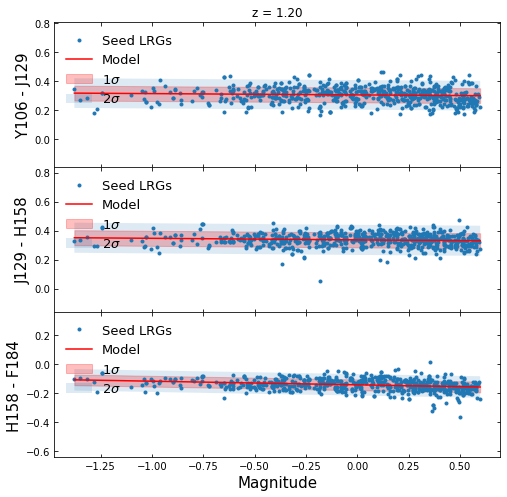

In [239]:
fr = ['Y106','J129','H158','F184']
z_low = 1.2
z_high = z_low + 0.025
z_mask = (zs > z_low) & (zs < z_high)

f,ax = plt.subplots(3,1,figsize = (8,8))
ax[0].set_title('z = %.2f'%z_low)
plt.subplots_adjust(hspace=0.0)
for kk in range(3):
    
    m_ref_mean,mag_ref,color,color_err = get_vals(c1 = fr[kk],c2 = fr[kk+1],ref_m=fr[-1],z_mask=z_mask)
    x0 = (1,0.5,0.002)
    res = minimize(func, x0,bounds=[(None,None),(None,None),(0,None)],args=(mag_ref,m_ref_mean,color,color_err))
    plot_model(ax = ax[kk], mag_ref=mag_ref,m_ref_mean=m_ref_mean,res=res.x,c1=fr[kk],c2 = fr[kk+1])
    try_m[0,kk*3:kk*3 + 3] = res.x

In [10]:
fr = ['Y106','J129','H158','F184']
zs_low = np.arange(1.2,1.8-0.025,0.025)
# 0: c
# 1: s
# 2: c_ii
# 3: m_ref
parm_vals = np.zeros(shape = (zs_low.shape[0],12))

for i,z_low in tqdm(enumerate(zs_low)):
    z_high = z_low + 0.025
    z_mask = (zs > z_low) & (zs < z_high)

    # loop over colors
    for kk in range(3):

        m_ref_mean,mag_ref,color,color_err = get_vals(c1 = fr[kk],c2 = fr[kk+1],ref_m=fr[-1],z_mask=z_mask)
        x0 = (1,0.5,0.002)
        res = minimize(func, x0,bounds=[(None,None),(None,None),(0,None)],args=(mag_ref,m_ref_mean,color,color_err))
        parm_vals[i,4*kk:4*kk+4] = np.append(res.x,m_ref_mean)

24it [00:46,  1.94s/it]


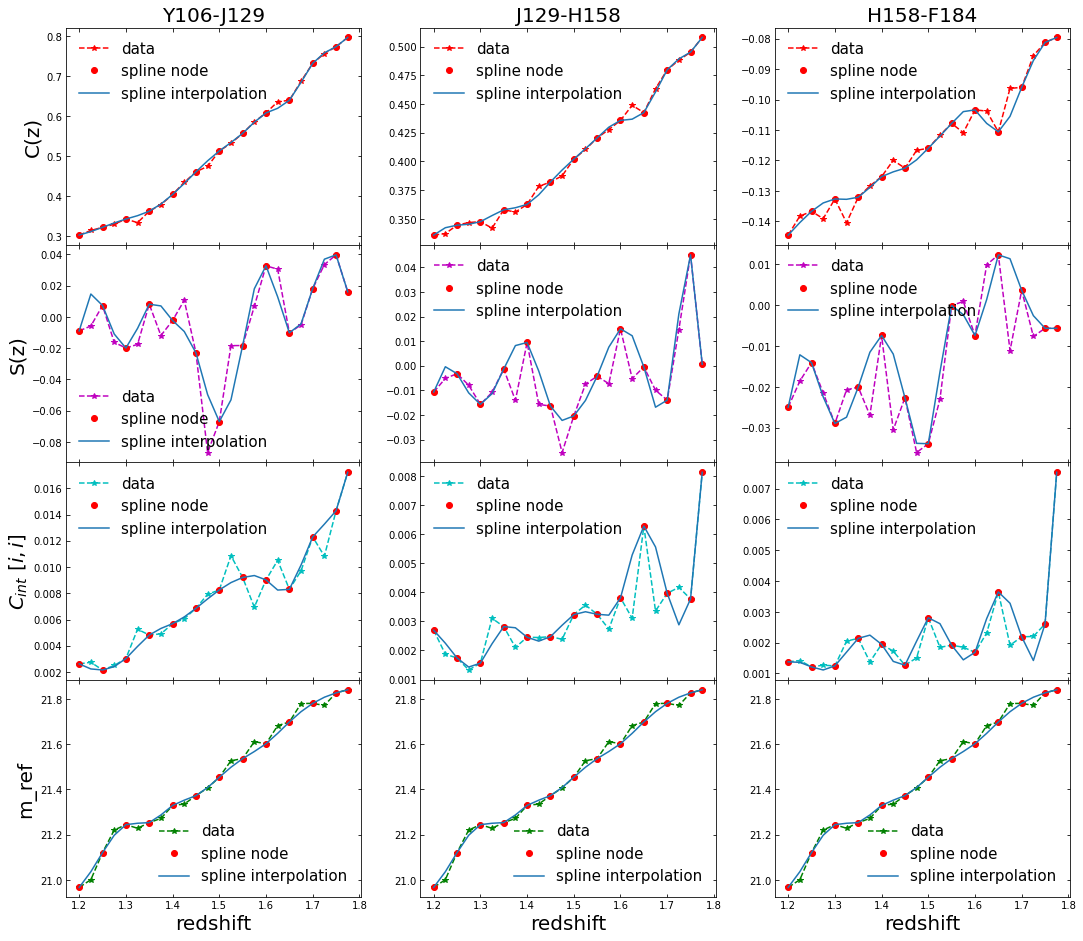

In [48]:
interpolators = {}
f,ax = plt.subplots(4,3,figsize = (18,16),sharex= True)
colors = ['r','m','c','g']
labels = ['C(z)','S(z)',r'$C_{int}\ [i,i]$','m_ref']
interp_name = ['c1','c2','c3','s1','s2','s3','sigma1','sigma2','sigma3','mref1','mref2','mref3']
plt.subplots_adjust(hspace= 0.0)
node_num = [2,2,2,2]
count = 0
for j in range(4):
    for k in range(3):
        ax[0][k].set_title( ('%s-%s')%(fr[k],fr[k+1]),fontsize = 20)
        node_z = []
        node_val = []

        ax[j][k].plot(zs_low,(parm_vals[:,k*4+j]),'*--',color = colors[j],label = 'data')

        ax[-1][k].set_xlabel('redshift',fontsize = 20)
        
        for ii in range(len(parm_vals[:,k*4+j])):
            
            if ii % node_num[j] == 0 or ii == 0 or ii == len(parm_vals[:,k*4+j])-1:
                node_z.append(zs_low[ii])
                node_val.append(parm_vals[:,k*4+j][ii])        
        f = interp1d(node_z, node_val, kind='cubic')
        interpolators[interp_name[count]] = f
        count += 1
        ax[j][k].plot(node_z,node_val,'ro',label = 'spline node')
        ax[j][k].plot(zs_low,f(zs_low),'-',label = 'spline interpolation')
        if k == 0:
            ax[j][k].set_ylabel(labels[j],fontsize = 20)
        ax[j][k].legend(fontsize = 15,frameon = False)
#plt.savefig('plots/red_sequence_model_parms_C_ii.pdf')

In [18]:
def get_vals2 (c1,c2,c3,c4,ref_m,z_mask):
    fz = 20
    mag_c0 = measured_qts['mag_auto_%s'%c1][z_mask]
    mag_c1 = measured_qts['mag_auto_%s'%c2][z_mask]
    mag_c2 = measured_qts['mag_auto_%s'%c3][z_mask]
    mag_c3 = measured_qts['mag_auto_%s'%c4][z_mask]
    mag_ref = measured_qts['mag_auto_%s'%ref_m][z_mask]
    
    color1 = mag_c0-mag_c1
    color2 = mag_c2-mag_c3
    mag_c0_err = measured_qts['magerr_auto_%s'%c1][z_mask]
    mag_c1_err = measured_qts['magerr_auto_%s'%c2][z_mask]
    mag_c2_err = measured_qts['magerr_auto_%s'%c3][z_mask]
    mag_c3_err = measured_qts['magerr_auto_%s'%c4][z_mask]
    
    return(np.mean(mag_ref),mag_ref,color1,color2,mag_c0_err**2,mag_c1_err**2,mag_c2_err**2,mag_c3_err**2)

In [19]:
#def func_off_diag_only (x,color1,color2,color3,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2,sigma_c3,a1,b1,sigma_int1,a2,b2,sigma_int2,a3,b3,sigma_int3):
def func_off_diag_only (x,color1,color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2,sigma_c3,a1,b1,sigma_int1,a2,b2,sigma_int2):    
    r = x 
    vals = np.zeros(shape = mag_ref.shape)
    for i,m_f in enumerate(mag_ref):
        
        c1_model = a1 + b1 * (m_f - m_ref_mean)
        c2_model = a2 + b2 * (m_f - m_ref_mean)
        #c3_model = a3 + b3 * (m_f - m_ref_mean)
        color_vec_model = np.array([[c1_model],[c2_model]])#[c3_model]])
        color_data = np.array([[color1[i]],[color2[i]]])#,[color3[i]]])
        
        # difference between model and data 
        vector = color_data - color_vec_model
        
        # Photometric covariance
        C_pho = np.empty((2,2))
        C_pho[0][0] = sigma_c0[i] + sigma_c1[i]    #color_err1[i]
        C_pho[1][1] = sigma_c2[i] + sigma_c3[i]
        #C_pho[2][2] = sigma_c2[i] + sigma_c3[i]
        if sigma_c1[i] == sigma_c2[i]:
            C_pho[1][0] = C_pho[0][1] = -sigma_c1[i]
        else:
            C_pho[1][0] = C_pho[0][1] = 0
        #C_pho[1][2] = C_pho[2][1] = -sigma_c2[i]
        #C_pho[0][2] = C_pho[2][0] = 0
        
        # Red sequence intrinsic scatter covariance
        C_int = np.empty((2,2))
        C_int[0][0] = sigma_int1
        C_int[1][1] = sigma_int2
        #C_int[2][2] = sigma_int3
        
        C_int[0][1] = C_int[1][0] = np.sqrt(sigma_int1)*np.sqrt(sigma_int2)*r
        #C_int[1][2] = C_int[2][1] = np.sqrt(sigma_int2)*np.sqrt(sigma_int3)*r2
        #C_int[0][2] = C_int[2][0] = np.sqrt(sigma_int1)*np.sqrt(sigma_int3)*r3
  
        C_tot = C_pho + C_int
        C_inv = inv(C_tot)
        vals[i] = np.linalg.multi_dot([vector.T,C_inv,vector]) + np.log((2*np.pi)*det(C_tot)) + (r/0.45)**2/2.
    return(np.sum(vals))

In [222]:
fr = ['Y106','J129','H158','F184']
z_low = 1.2
z_high = z_low + 0.025
z_mask = (zs > z_low) & (zs < z_high)
m_ref_mean,mag_ref,color1,color2,sigma_c0,sigma_c1,sigma_c2,sigma_c3= get_vals2(c1 = fr[0],c2 = fr[1],c3 = fr[1],c4 = fr[2],ref_m=fr[-1],z_mask=z_mask)
x0 = (0)
res = minimize(func_off_diag_only,x0,
              args=(color1, color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2,sigma_c3,
                    parm_vals[0][0],parm_vals[0][1],parm_vals[0][2],parm_vals[0][4],parm_vals[0][5],
                    parm_vals[0][6]))

In [21]:
zs_low =  np.arange(1.2,1.8-0.025,0.025)
color_pair = [[0,1],[1,2],[0,2]]
data_pair = [[0,1,1,2],[1,2,2,3],[0,1,2,3]]
r_array = np.zeros(shape = (len(zs_low),3))
for i,z_low in tqdm(enumerate(zs_low)):
    z_high = z_low + 0.025
    z_mask = (zs > z_low) & (zs < z_high)
    
    for k in range(3):
        data_p = data_pair[k]
        color_idx1 = color_pair[k][0]
        color_idx2 = color_pair[k][0]
        m_ref_mean,mag_ref,color1,color2,sigma_c0,sigma_c1,sigma_c2,sigma_c3 = get_vals2(c1 = fr[data_p[0]],c2 = fr[data_p[1]],c3 = fr[data_p[2]],c4 = fr[data_p[3]],ref_m=fr[-1],z_mask=z_mask)
        x0 = (0)

        res = minimize(func_off_diag_only,x0,bounds=[(-1,1)],
                      args=(color1, color2,mag_ref,m_ref_mean,sigma_c0,sigma_c1,sigma_c2,sigma_c3,
                            parm_vals[i][color_idx1*4],parm_vals[i][color_idx1*4+1],parm_vals[i][color_idx1*4+2],
                            parm_vals[i][color_idx2*4],parm_vals[i][color_idx2*4+1],parm_vals[i][color_idx2*4+2]))
        r_array[i,k] = res.x

24it [00:34,  1.45s/it]


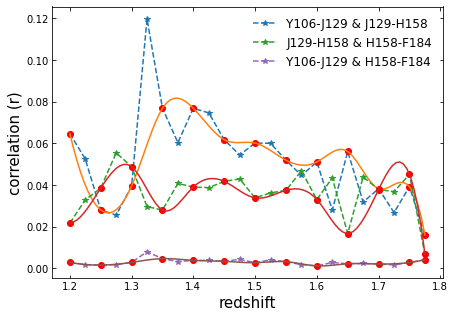

In [49]:
zss = np.linspace(1.2,1.775,100)
node_num = 2
plt.figure(figsize = (7,5))
color_pair = [[0,1,1,2],[1,2,2,3],[0,1,2,3]]
interp_n = ['r1','r2','r3']
count = 0
for k in range(3):
    node_z = []
    node_val = []
    plt.plot(zs_low,r_array[:,k],'*--',label = '%s-%s & %s-%s'%(fr[color_pair[k][0]],fr[color_pair[k][1]],fr[color_pair[k][2]],fr[color_pair[k][3]]))

    

    for ii in range(len(r_array[:,k])):
        if ii % node_num == 0 or ii == 0 or ii == (len(parm_vals[:,k*4+j])-1):
            node_z.append(zs_low[ii])
            node_val.append(r_array[:,k][ii])        
    f = interp1d(node_z, node_val, kind='cubic',fill_value='extrapolate')
    interpolators[interp_n[count]] = f
    count += 1
    plt.plot(node_z,node_val,'ro')
    plt.plot(zss,f(zss),'-')
    plt.ylabel('correlation (r)',fontsize = 15)
    plt.xlabel('redshift',fontsize = 15)
    plt.legend(fontsize = 12,frameon = False)
#plt.savefig('plots/red_sequence_off_diag_r.pdf')

In [57]:
import pickle

In [58]:
filename = 'data/Interpolator/True_seed_gal_RS.pkl'
outfile = open(filename,'wb')
pickle.dump(interpolators,outfile)
outfile.close()

In [51]:
interpolators

{'c1': <scipy.interpolate._interpolate.interp1d at 0x15541466e2c0>,
 'c2': <scipy.interpolate._interpolate.interp1d at 0x1554148b4310>,
 'c3': <scipy.interpolate._interpolate.interp1d at 0x15541486b180>,
 's1': <scipy.interpolate._interpolate.interp1d at 0x155414880ae0>,
 's2': <scipy.interpolate._interpolate.interp1d at 0x1554148b44f0>,
 's3': <scipy.interpolate._interpolate.interp1d at 0x155414615900>,
 'sigma1': <scipy.interpolate._interpolate.interp1d at 0x155414880950>,
 'sigma2': <scipy.interpolate._interpolate.interp1d at 0x1554148b4360>,
 'sigma3': <scipy.interpolate._interpolate.interp1d at 0x155414863e00>,
 'mref1': <scipy.interpolate._interpolate.interp1d at 0x155414677a90>,
 'mref2': <scipy.interpolate._interpolate.interp1d at 0x155414605950>,
 'mref3': <scipy.interpolate._interpolate.interp1d at 0x155414615ae0>,
 'r1': <scipy.interpolate._interpolate.interp1d at 0x155416ed83b0>,
 'r2': <scipy.interpolate._interpolate.interp1d at 0x155417069d10>,
 'r3': <scipy.interpolate._